# Pre-process & DataLoader

- 필요한 라이브러리 설정

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from torchsummary import summary

In [9]:
''' seed값 고정 : torch에서 사용되는 random값을 항상 같은 값이 나오도록 설정 '''
SEED = 86
torch.manual_seed(SEED)
print(torch.rand(1))

tensor([0.8674])


In [10]:
''' torch.device('cuda')를 사용하여 학습 시 gpu를 사용할 수 있도록 설정'''
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.1+cu116  Device: cuda


In [11]:
''' 학습할 때 모델에 한번에 입력할 데이터 갯수(batch size)와 epoch 설정'''
BATCH_SIZE = 32
EPOCH = 5

- 파일 경로 설정

In [13]:
''' data 불러오기 (CIFAR10) '''

# transform.Compose을 이용하여 이미지 사이즈 변경 및 데이터 타입을 변경할 수 있음
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()]
)

train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transform)

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transform)

# dataloader를 통해 batch size 설정과 데이터를 섞어서 학습에 사용할지를 결정할 수 있음
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


- 파일 불러오기

x_train : torch.Size([32, 224, 224, 3]) type : torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


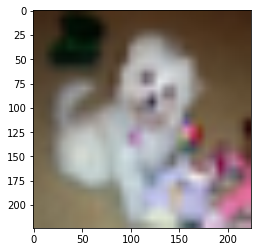

In [16]:
# iter : 반복가능한 변수의 값을 하나씩 참조할 수 있음
# next : iter를 통해 참조한 값을 반환하고 변수의 그 다음 위치를 참조하게 됨

x_train, y_train = next(iter(train_loader))
print('x_train :', x_train.permute(0, 3, 2, 1).shape, 'type :', x_train.type())
print('y_train :', y_train.shape, 'type :', y_train.type())
plt.imshow(x_train[1].permute(1, 2, 0))

# Models

- train and test code

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for batch_idx, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(DEVICE)            # .to(DEVICE) : 데이터와 모델의 gpu 호환을 위해서 사용
        y_train = y_train.to(DEVICE)    

        output = model(x_train)                 # model에 훈련데이터 입력 후 변수 output에 출력값 저장
        loss = criterion(output, y_train)       # loss function을 통해 모델의 출력값과 실제 값과의 차이를 계산

        optimizer.zero_grad()                   # optimizer.zero_grad() : loss.backward()를 통해 미분을 하게 되면 optimizer에 미분값이 저장되는데 
                                                #                         미분을 진행할 때 마다 미분값이 누적되어서 정상적으로 파라미터를 업데이트 할 수 없게 되는데 
                                                #                         zero_grad()를 사용하므로써 누적된 값을 초기화 시켜줄 수 있다.
        loss.backward()                         # back propagation을 통해 각 layer 마다 미분값 계산
        optimizer.step()                        # optimizer.step() : 파라미터 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(x_train), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## LeNet

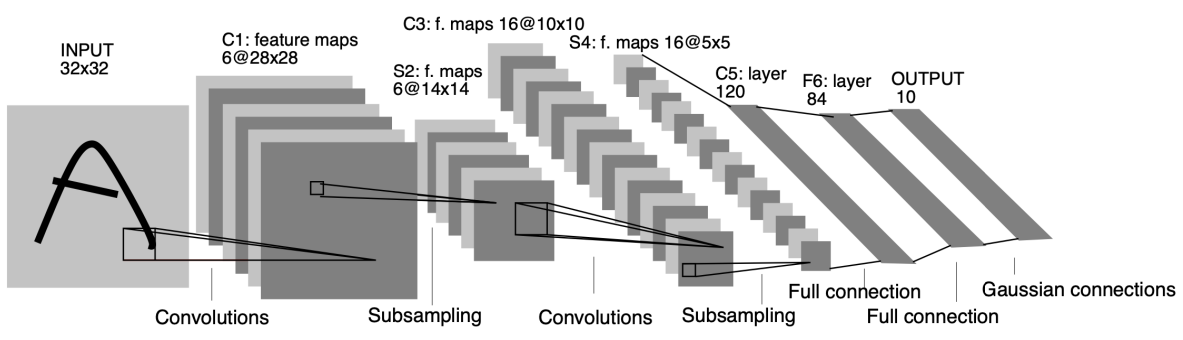

In [ ]:
class LeNet(nn.Module):

    def __init__(self, channels=3, n_classes=10):
        super(LeNet, self).__init__()       # __init__() 메서드 안에 입력하게 되면 부모 클래스에서 정의된 값들을 불러올 수 있다.
                                            #    ==> nn.Module의 값들을 LeNet에 불러오겠다는 의미
        
        self.Convolution_layer = nn.Sequential(                                         # nn.Sequential : 네트워크의 layer를 쉽게 쌓을 수 있게 만들어 주는 메서드
            # ============================== layer 1 =================================  # input image size : 224x224
            nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5, stride=1),   # image size : 6 x ((224 - 5) / 1 + 1) = 6 x 220 x 220
            nn.Tanh(),                                                                  # image size : 6 x 220 x 220 ==> activation function에서는 이미지 크기가 변하지 않음
            nn.AvgPool2d(kernel_size=2),                                                # image size : 6 x 110 x 110

            #=============================== layer 2 =================================  
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),         # image size : 16 x ((110 - 5) / 1 + 1) = 16 x 106 x 106
            nn.Tanh(),                                                                   
            nn.AvgPool2d(kernel_size=2),                                                # image size : 16 x 53 x 53

            # ============================== layer 3 =================================  
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),       # image size : 120 x ((53 - 5) / 1 + 1) = 120 x 49 x 49
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            # ============================== layer 4 =================================
            nn.Linear(in_features=120 * 49 * 49, out_features=84),                      # nn.Linear : fully connected layer 구성 ==> 1차원 형태로 입력을 받게 됨
            nn.Tanh(),                                                                  # input image size : 120 x 49 x 49
                                                                                        # output image size : 84
            # ============================ output layer ==============================
            nn.Linear(in_features=84, out_features=n_classes),                          # output image size : 클래스 갯수(10개)
        )


    def forward(self, x):       # forward를 통해 데이터를 입력받고, 입력받은 데이터의 특징을 추출할 수 있는 연산이 진행된다.
        x = self.Convolution_layer(x) 
        x = x.view(-1, 120 * 49 * 49)   # x.view(-1, data size)     
        x = self.classifier(x)
        x = F.softmax(x, dim=1)                                                         # softmax 함수를 통해 output 값을 확률값으로 나타내줌
        return x

In [ ]:
model = LeNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
         MaxPool2d-3          [-1, 8, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]           1,168
              ReLU-5         [-1, 16, 112, 112]               0
         MaxPool2d-6           [-1, 16, 56, 56]               0
            Linear-7                   [-1, 64]          65,600
            Linear-8                   [-1, 32]           2,080
            Linear-9                   [-1, 10]             330
Total params: 69,402
Trainable params: 69,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 10.34
Params size (MB): 0.26
Estimated Total Size (MB): 11.18
-------------------------------------------

In [ ]:
for epoch in range(1, EPOCH+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.301482
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.230896
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.180029
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.215112
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.123043
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.123994
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.171939
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.133701

[EPOCH: 1], 	Test Loss: 2.1456, 	Test Accuracy: 35.82 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.167217
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.124221
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.144766
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.059565
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.135522
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 2.089206
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.135447
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.121238

[EPOCH: 2], 	Test Loss: 2.1159, 	Test Accuracy: 39.34 % 

## AlexNet

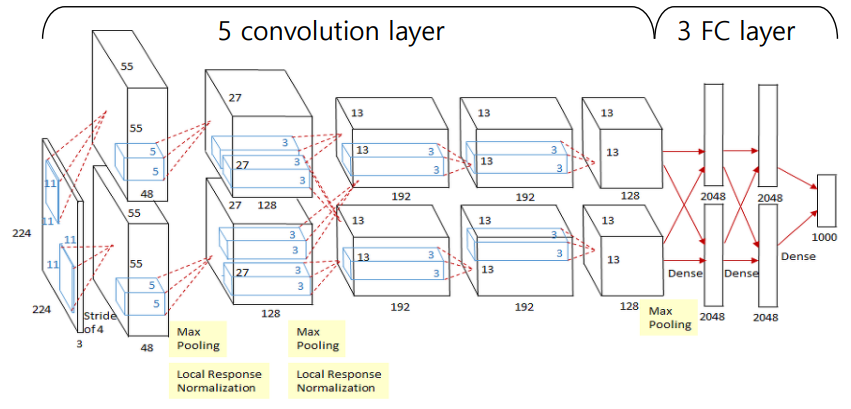

In [ ]:
# AlexNet

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet,self).__init__()

        # Conv layer
        self.net = nn.Sequential(
            # convolution layer 5 개
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),      # actiavtion function : ReLU 사용
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),     # Local Response Normalization 
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),

            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),

            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
        )

        # Fully connected layer 3개
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 5 * 5), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

    
    def forward(self,x):
        x = self.net(x)
        x = x.view(-1, 256 * 5 * 5)
        x = self.classifier(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
 LocalResponseNorm-3           [-1, 96, 54, 54]               0
         MaxPool2d-4           [-1, 96, 26, 26]               0
            Conv2d-5          [-1, 256, 26, 26]         614,656
              ReLU-6          [-1, 256, 26, 26]               0
 LocalResponseNorm-7          [-1, 256, 26, 26]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]         885,120
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]       1,327,488
             ReLU-12          [-1, 384, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         884,992
             ReLU-14          [-1, 256,

In [ ]:
for epoch in range(1, EPOCH+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.302624
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.287017
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.173518
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.251671
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.203097
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.260905
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.182506
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.178517

[EPOCH: 1], 	Test Loss: 2.1482, 	Test Accuracy: 30.28 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.149019
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.106953
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.217614
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.203688
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.051034
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 2.205173
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.058365
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.195168

[EPOCH: 2], 	Test Loss: 2.1135, 	Test Accuracy: 34.11 % 

## VGGNet

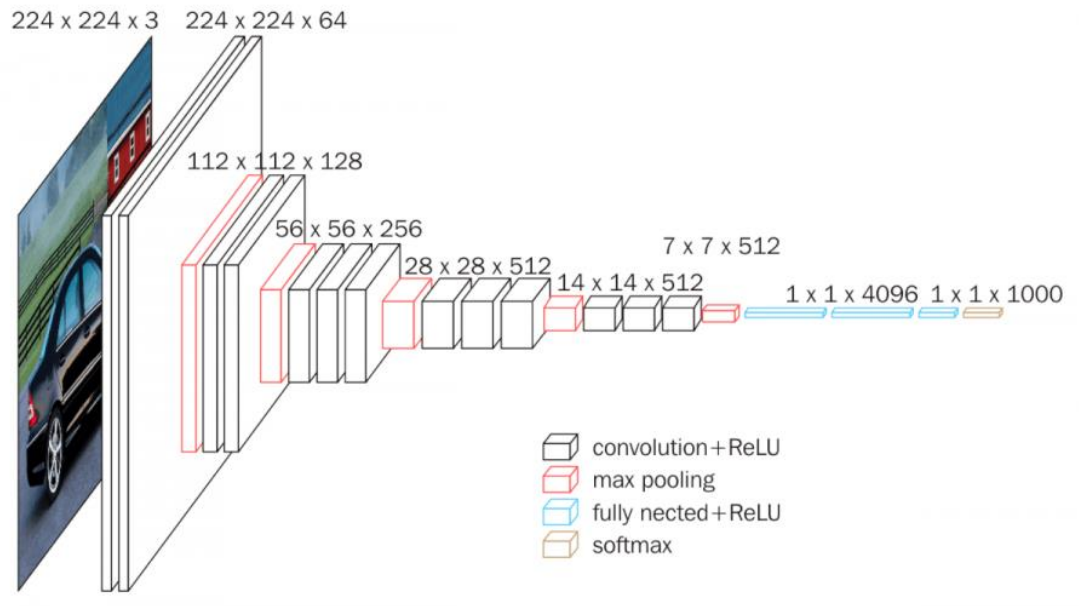

In [ ]:
# VGG

# int : output chnnels after conv layer
# 'M' : max pooling layer

VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M']
}


class VGGNet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10):
        super(VGGNet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(VGG_types[model])

        
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.fcs(x)
        x = F.softmax(x, dim=1)
        return x

    
    # 미리 정의한 vggnet 구조를 입력으로 받아 다음 함수를 통해 각 layer를 생성함
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:  # 위에서 정의한 vgg_types를 참고하게 됨
            if type(x) == int: # convolution layer 만들기
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M': # max pooling 
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        
        return nn.Sequential(*layers)

In [ ]:
model = VGGNet('VGG16').to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
for epoch in range(1, EPOCH+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.301117
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.168405
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.057130
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.011679
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.923884
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.899960
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.992119
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.889540

[EPOCH: 1], 	Test Loss: 1.9622, 	Test Accuracy: 50.16 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.926934
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.934727
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.934141
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.896936
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.929132
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.911412
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.845706
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.815810

[EPOCH: 2], 	Test Loss: 1.8747, 	Test Accuracy: 58.85 % 

# transfer learning

- 전이학습(Transfer Learning)
  * 데이터가 적은 상황에서 미리 학습해 놓은 딥러닝 모델(Pre-Trained Model)을 가져와서 재학습(Fine-tuning) 시키는 방법

  * Fine-tuning
    * Fully Connected Layer 이전의 weight는 Freezing
    * Fully Connected Layer의 가중치만 학습을 진행하는 것

  * Transfer Learning은 Initialization의 개념으로 바라볼 수도 있다.


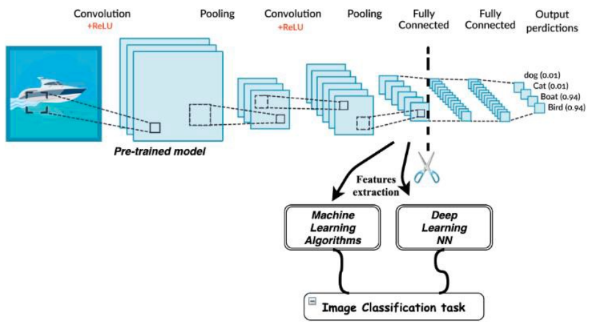

## Fine-Turning 방법

1. 전체 모델을 새로 학습시키는 방법
2. Convolutional base의 일부분은 고정시킨 상태로, 나머지 layer와 classifier를 새로 학습시키는 방법
3. convolution base는 고정시키고, classifier만 새로 학습시키는 방법

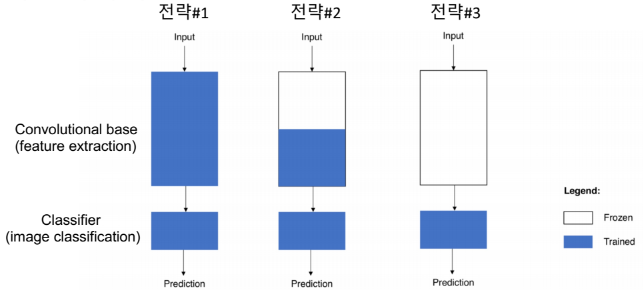

- 데이터 크기-유사성에 따른 Fine-Tuning 방법

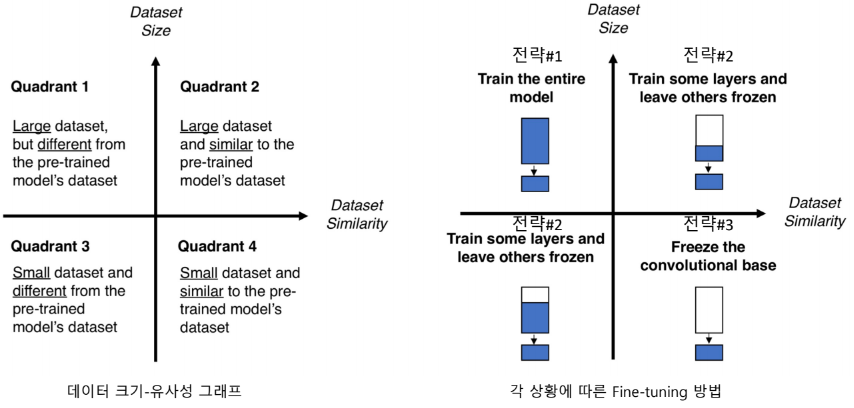

- 전략 1 
  - 데이터 셋이 충분히 많고, pre-trained model의 데이터 셋과 다를 때

- 전략 2
  - 데이터 셋이 충분하고, pre-trained model의 데이터 셋과 비슷할 때

- 전략 3
  - 데이터 셋도 적고, pre-trained model의 데이터 셋과도 다를 때

- 전략 4
  - 데이터 셋은 적지만, pre-trained model의 데이터 셋과 비슷할 때

## Transfer Learning Code

In [31]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [32]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.1+cu116  Device: cuda


In [33]:
BATCH_SIZE = 32
EPOCHS = 3

In [34]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기 (Train set, Test set 분리하기) '''

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),                          # 이미지에서 랜덤한 위치에서 224x224로 잘라내는 함수
        transforms.RandomHorizontalFlip(),                          # 랜덤하게 이미지를 선택해서 좌우 반전시키는 함수
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])      # image normalization
    ]),
    'val': transforms.Compose([                                     # 이미지의 가운데를 224x224 크기로 잘라내는 함수
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_path = "/content/drive/MyDrive/Colab Notebooks/심화프로그래밍/week10/hymenoptera_data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(data_path, data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

In [35]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


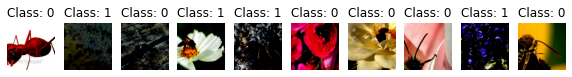

In [23]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [36]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [37]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [38]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
torch.manual_seed(SEED)

import torchvision.models as models
model = models.resnet18(pretrained = False)
num_ftrs = model.fc.in_features
print(num_ftrs)
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)

512


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [27]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
from torchvision import datasets

In [ ]:
''' 10. 미리 학습되지 않은 ResNet18 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.778181
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.644042
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.719156

[EPOCH: 1], 	Test Loss: 0.7219, 	Test Accuracy: 55.42 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.601759
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.770100
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.747858

[EPOCH: 2], 	Test Loss: 0.7190, 	Test Accuracy: 61.46 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.600293
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.632604
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.647957

[EPOCH: 3], 	Test Loss: 0.7048, 	Test Accuracy: 60.45 % 



In [ ]:
''' 11. IMAGENET 데이터로 미리 학습이 된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기 '''
torch.manual_seed(SEED)

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.875428
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.687990
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.730785

[EPOCH: 1], 	Test Loss: 0.6815, 	Test Accuracy: 63.22 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.676260
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.594922
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.610657

[EPOCH: 2], 	Test Loss: 0.5104, 	Test Accuracy: 77.83 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.531663
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.434284
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.422569

[EPOCH: 3], 	Test Loss: 0.4316, 	Test Accuracy: 86.40 % 



In [45]:
''' 모델의 파라미터 확인 및 freeze'''
torch.manual_seed(SEED)
model = models.resnet18(pretrained = True)
for layer_name, params in model.named_parameters():
    print(layer_name)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [46]:
'''conv1.weight 에 해당되는 파라미터 확인'''
model.get_parameter('layer4.0.conv1.weight')

Parameter containing:
tensor([[[[-1.1645e-02, -1.9010e-02, -2.1876e-02],
          [ 2.0482e-02,  2.3962e-02,  2.9161e-02],
          [ 4.3672e-02,  3.3278e-02,  4.9908e-02]],

         [[-7.4040e-03,  2.8083e-03, -4.7339e-03],
          [ 6.9030e-03,  1.4271e-02, -3.6954e-03],
          [-3.1341e-03,  1.3736e-02,  1.6127e-03]],

         [[ 1.8676e-02, -1.0553e-02, -1.4233e-02],
          [ 8.9944e-03, -2.5068e-03, -1.2145e-02],
          [-4.9455e-03, -2.9206e-02, -9.6385e-03]],

         ...,

         [[-1.2655e-02,  1.7691e-02,  9.8264e-04],
          [ 7.4271e-03,  7.6115e-03,  1.1135e-02],
          [ 2.3242e-02,  1.1058e-02,  4.0498e-03]],

         [[ 1.8557e-02,  1.2472e-02,  1.7220e-02],
          [-4.8544e-03,  8.3627e-03,  2.2811e-02],
          [-5.1675e-03,  2.3264e-02,  3.4068e-02]],

         [[ 2.4934e-02,  2.2373e-02,  4.2614e-02],
          [ 1.3486e-02,  1.6760e-03,  1.3019e-02],
          [-6.2821e-03, -1.5112e-03, -8.9229e-03]]],


        [[[-9.8089e-04, -6.3011

In [48]:
'''.require_grad=Fasle를 통해 파라미터가 더이상 업데이트 안되도록 설정'''
model.get_parameter('layer4.0.conv1.weight').require_grad = False 
model.get_parameter('layer4.0.conv1.weight').require_grad

False

In [ ]:
''' 마지막 레이어(FC Layer)만 학습 시키기 '''
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


In [ ]:
for name, param in model.named_parameters():
    print(name, ':', param.requires_grad)

In [ ]:
''' 12. IMAGENET 데이터로 미리 학습이 된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기 '''
torch.manual_seed(SEED)
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))
    

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.875428
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.689560
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.698099

[EPOCH: 1], 	Test Loss: 0.7401, 	Test Accuracy: 58.44 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.718004
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.818044
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.750124

[EPOCH: 2], 	Test Loss: 0.7405, 	Test Accuracy: 60.45 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.721903
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.699703
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.526377

[EPOCH: 3], 	Test Loss: 0.7344, 	Test Accuracy: 57.68 % 



# Code practice

CNN 모델로 MNIST, CIFAR10 데이터 셋 학습시켜보기

- 모든 convolution filter 크기 3으로 설정
- padding size = 1로 설정 
- Maxpooling 설정
    - kernel(filter) size : 2
    - stride : 2

========= Convolution Layer =========

[layer1]

- convolution : output channel = 8 
- ReLU
- Maxpooling


[layer2]

- convolution : output channel = 16
- ReLU
- Maxpooling

=================================

============= FC layer =============

[layer1]

- Linear : output size = 64

[layer2]

- Linear : output size = 32

[layer3]

- Linear : output size = 10

=================================

In [ ]:
# CIFAR10 사용하려면 MNIST를 CIFAR10으로 모두 바꿔주시면 됩니다.

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root = "../data/MNIST",
                                  train = True,
                                  download = True,
                                  transform = transform)

test_dataset = datasets.MNIST(root = "../data/MNIST",
                                train = False,
                                transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [ ]:
x_train, y_train = next(iter(train_loader))
print('x_train :', x_train.shape, 'type :', x_train.type())
print('y_train :', y_train.shape, 'type :', y_train.type())

x_train : torch.Size([32, 1, 28, 28]) type : torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


In [ ]:
# MNIST
class CNN_mnist(nn.Module):
    def __init__(self):
        super(CNN_mnist, self).__init__()
        self.convolution_layers = nn.Sequential(
            # 1. convolution 2. activation function 3. pooling 순서로 layer 쌓아주기
        )

        self.FC_layers = nn.Sequential(
            # convolution output size 고려해서 첫번재 FC layer 만들어주기
        )

    def forward(self, x):
        # convolution 연산

        # x.view(-1, ) 사용해서 차원 맞춰주기

        # Fully connected 연산
        
        x = F.softmax(x, dim=1)
        return x

In [ ]:
model = CNN_mnist().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
#summary(model, (1, 28, 28)) # MNIST 확인용
#summary(model, (3, 32, 32)) # CIFAR10 확인용

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Linear-7                   [-1, 64]          50,240
            Linear-8                   [-1, 32]           2,080
            Linear-9                   [-1, 10]             330
Total params: 53,898
Trainable params: 53,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.21
Estimated Total Size (MB): 0.37
---------------------------------------------

In [ ]:
for epoch in range(1, EPOCH+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))